# Set Membership PINN

## PINN pre-training

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax
import optax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, grad, vmap, random
from functools import partial
from tqdm import trange

SEED = 1
STRUCTURE = [1] + 5*[20] + [1]
XMIN = 0
XMAX = 1

### Utilities

In [2]:
def random_layer_params(m, n, key, scale):
    w_key, b_key = random.split(key)
    return scale*random.normal(w_key, (m, n)), jnp.zeros(n)

def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, 2.0/(jnp.sqrt(m+n))) \
            for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def predict(params, H):
    for w, b in params[:-1]:
        H = jnp.tanh(jnp.dot(H, w) + b)
    w_final, b_final = params[-1]
    return jnp.dot(H, w_final) + b_final

def net(params, x, lb, ub):
    H = 2.0 * (x - lb) / (ub - lb) - 1.0
    return predict(params, H)

def net4grad(params, x, lb, ub):
    return net(params, x, lb, ub)[0, 0]

def net__t(params, x, lb, ub):
    return grad(net4grad, 1)(params, x, lb, ub)

def net__x(params, x, lb, ub):
    return grad(net4grad, 1)(params, x, lb, ub)

def net__xx(params, x, lb, ub):
    return grad(net__x, 1)(params, x, lb, ub)

In [3]:
net_vmap = jit(vmap(net, in_axes=(None, 0, None, None)))
net__xx_vmap = jit(vmap(net__xx, in_axes=(None, 0, None, None)))

### Data generation

In [4]:
OUTPUT_EPS = 1e-3
BOUND_EPS = 1e-3

In [5]:
@jit
def analytic_solution(x):
    return jnp.pow(jnp.cos(2*jnp.pi*x), 3)

u__x = jit(grad(analytic_solution))
u__xx = jit(grad(u__x))

def forcing(x):
    return 0.01 * u__xx(x) - 0.1 * analytic_solution(x)

f_vmap = jit(vmap(forcing))

In [6]:
key = random.PRNGKey(SEED)

key, new_key = random.split(key)
bound_values = 1 + 2 * BOUND_EPS * random.uniform(new_key, (2,)) - BOUND_EPS

N_SPACE = 50
key, new_key = random.split(key)
space = jnp.linspace(XMIN, XMAX, N_SPACE)
key, new_key = random.split(key)
values_error = 2 * OUTPUT_EPS * random.uniform(new_key, (N_SPACE,)) - OUTPUT_EPS
values = f_vmap(space) + values_error

### Losses

In [7]:
def residual_domain(params, x, lb, ub):
    u = net_vmap(params, x, lb, ub)
    u__xx = net__xx_vmap(params, x, lb, ub)

    return 0.01 * u__xx - 0.1 * u - values

@jit
def loss_domain(params, x, lb, ub):
    return jnp.mean(jnp.square(residual_domain(params, x, lb, ub)))

In [8]:
def residual_boundary(params, lb, ub):
    x = jnp.array([0, 1.0])
    u = net_vmap(params, x, lb, ub)

    return u - bound_values

@jit
def loss_boundary(params, lb, ub):
    return jnp.mean(jnp.square(residual_boundary(params, lb, ub)))

### Training

In [9]:
val_grad_domain = jit(jax.value_and_grad(loss_domain, argnums=0))
val_grad_boundary = jit(jax.value_and_grad(loss_boundary, argnums=0))

@jit
def training_step(params, 
                  opt_state, 
                  lb, 
                  ub,
                  lmb):
    #loss computation
    loss_domain, grad_domain = val_grad_domain(params, space, lb, ub)
    loss_boundary, grad_boundary = val_grad_boundary(params, lb, ub)

    def grad_composition(grad_domain, grad_boundary):
        return lmb[0] * grad_domain + lmb[1] * grad_boundary

    grads = jax.tree.map(grad_composition, grad_domain, grad_boundary)
    loss = lmb[0] * loss_domain + lmb[1] * loss_boundary
    
    
    #update parameters
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss, loss_domain, loss_boundary

In [10]:
N_EPOCHS = 10000
lmb = jnp.array([1.0, 1.0])
params = init_network_params(STRUCTURE, key)

schedule = optax.schedules.exponential_decay(1e-3, 1000, 0.99)
optimizer = optax.inject_hyperparams(optax.adam)(schedule)
opt_state = optimizer.init(params)

train_loss = jnp.zeros((N_EPOCHS,))
domain_loss = jnp.zeros((N_EPOCHS,))
boundary_loss = jnp.zeros((N_EPOCHS,))

pbar = trange(N_EPOCHS)
for i in pbar:
    out = training_step(params, opt_state, XMIN, XMAX, lmb)
    params = out[0]
    opt_state = out[1]
    train_loss = train_loss.at[i].set(out[2])
    domain_loss = domain_loss.at[i].set(out[3])
    boundary_loss = boundary_loss.at[i].set(out[4])

    pbar.set_postfix({
        'train_loss': out[2],
        'domain_loss': out[3],
        'boundary_loss': out[4]
    })

100%|██████████| 10000/10000 [00:27<00:00, 362.74it/s, train_loss=0.004393623, domain_loss=0.004153231, boundary_loss=0.00024039201]  


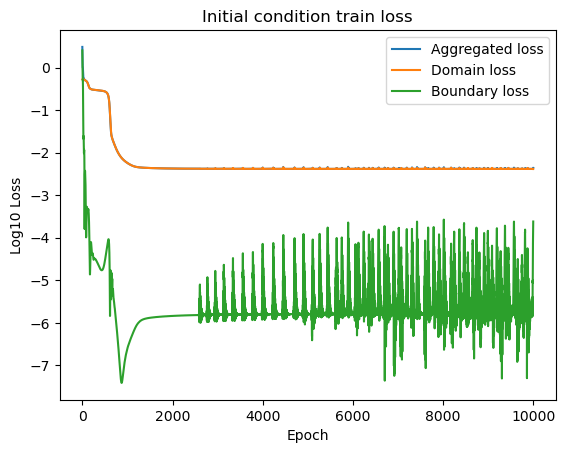

In [11]:
plt.figure()
plt.plot(jnp.log10(train_loss), label='Aggregated loss')
plt.plot(jnp.log10(domain_loss), label='Domain loss')
plt.plot(jnp.log10(boundary_loss), label='Boundary loss')
plt.title("Initial condition train loss")
plt.xlabel("Epoch")
plt.ylabel("Log10 Loss")
plt.legend()

### Test

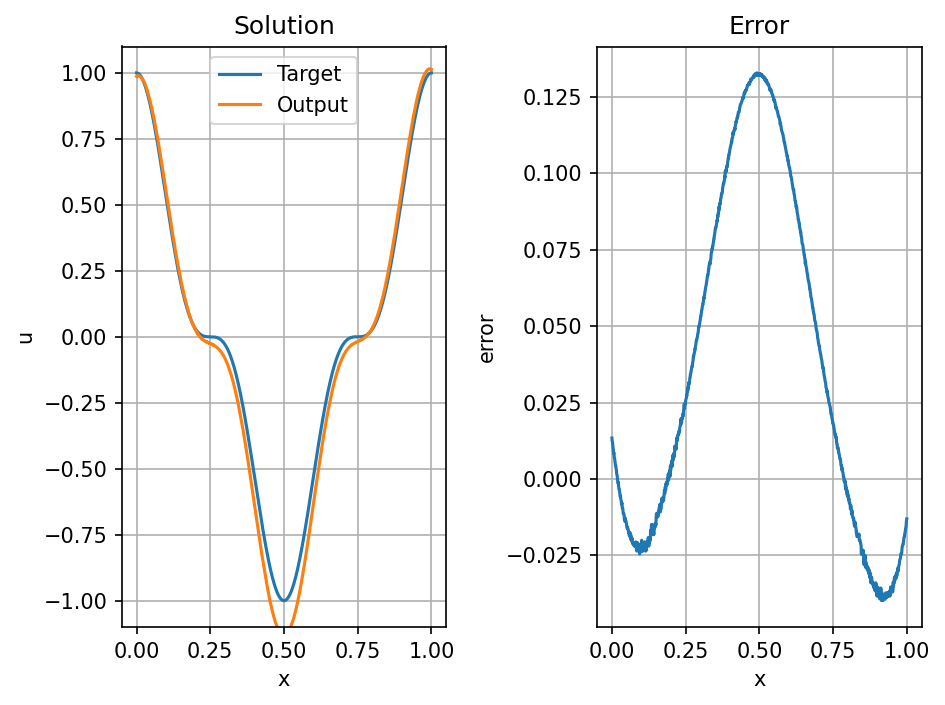

In [12]:
N_POINTS = 1000
xt_initial = jnp.linspace(XMIN, XMAX, N_POINTS, endpoint=True).reshape(-1)

out = net_vmap(params, xt_initial, XMIN, XMAX).reshape(-1)
target = analytic_solution(xt_initial).reshape(-1)

fig, axs = plt.subplots(1, 2, dpi=150, tight_layout=True)
axs[0].plot(xt_initial, target, label="Target")
axs[0].plot(xt_initial, out, label="Output")
axs[0].legend()
axs[0].grid()
axs[0].set_xlabel("x")
axs[0].set_ylabel("u")
axs[0].set_ylim(-1.1, 1.1)
axs[0].set_title(f'Solution')
axs[1].plot(xt_initial, target - out)
axs[1].set_xlabel("x")
axs[1].set_ylabel("error")
axs[1].grid()
axs[1].set_title(f'Error')
plt.savefig(f"sol.png")

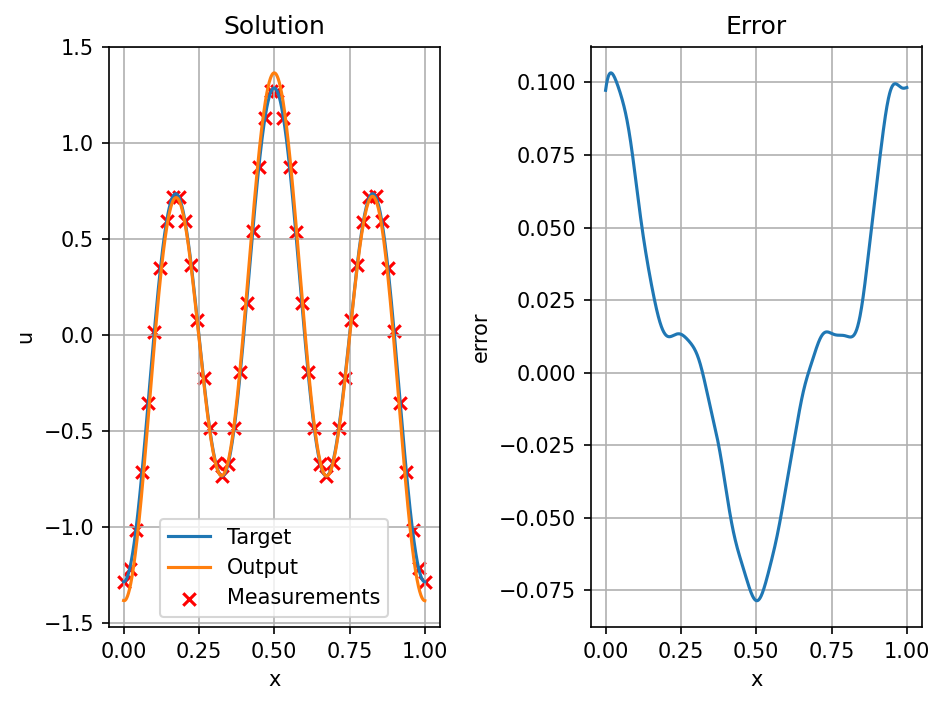

In [13]:
def f_est(params, x):
    return 0.01 * net__xx(params, x, XMIN, XMAX) - 0.1 * net(params, x, XMIN, XMAX)

f_est_vmap = jit(vmap(f_est, in_axes=(None, 0)))

N_POINTS = 1000
xt_initial = jnp.linspace(XMIN, XMAX, N_POINTS, endpoint=True).reshape(-1)

out = f_est_vmap(params, xt_initial).reshape(-1)
target = f_vmap(xt_initial).reshape(-1)

fig, axs = plt.subplots(1, 2, dpi=150, tight_layout=True)
axs[0].plot(xt_initial, target, label="Target")
axs[0].plot(xt_initial, out, label="Output")
axs[0].scatter(space, values, label="Measurements", marker='x', color='red')
axs[0].legend()
axs[0].grid()
axs[0].set_xlabel("x")
axs[0].set_ylabel("u")
axs[0].set_title(f'Solution')
axs[1].plot(xt_initial, target - out)
axs[1].set_xlabel("x")
axs[1].set_ylabel("error")
axs[1].grid()
axs[1].set_title(f'Error')
plt.savefig(f"sol.png")

## Uncertainty model

### Utilities

In [14]:
def predict_fc(params, H):
    for w, b in params[:-1]:
        H = jnp.tanh(jnp.dot(H, w) + b)
    return H

def net_fc(params, x, lb, ub):
    H = 2.0 * (x - lb) / (ub - lb) - 1.0
    return predict_fc(params, H)

def net4grad_fc(params, x, lb, ub):
    return net_fc(params, x, lb, ub)[0]

In [15]:
hessian = jax.jacfwd(jax.jacfwd(net4grad_fc, argnums=1), argnums=1)
hessian_vmap = jit(vmap(hessian, in_axes=(None, 0, None, None)))
net_fc_vmap = jit(vmap(net_fc, in_axes=(None, 0, None, None)))

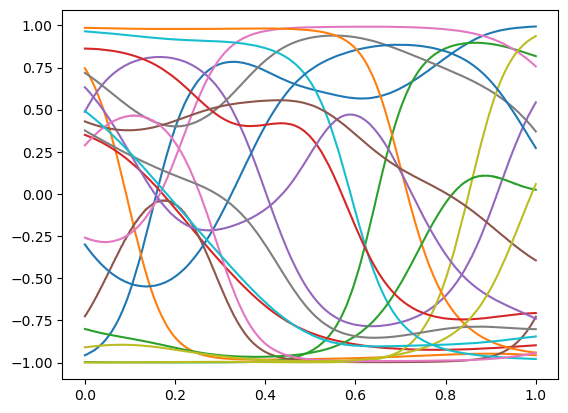

In [16]:
plt.plot(xt_initial, net_fc_vmap(params, xt_initial, XMIN, XMAX)[:, 0, :])

In [17]:
magnitude_order = jnp.argsort(params[-1][0][:,0])

### Constraints

In [18]:
data_block = 0.01 * hessian_vmap(params, space, XMIN, XMAX) - 0.1 * net_fc_vmap(params, space, XMIN, XMAX)[:,0,:]
data_block.shape

(50, 20)

In [19]:
data_block = jnp.concatenate([data_block, -0.1 * jnp.ones((N_SPACE, 1))], axis=1)
data_block.shape

(50, 21)

In [20]:
bound_block = net_fc_vmap(params, jnp.array([0,1]), XMIN, XMAX)[:,0,:]
bound_block.shape

(2, 20)

In [21]:
bound_block = jnp.concatenate([bound_block, jnp.ones((2,1))], axis=1)
bound_block.shape

(2, 21)

In [22]:
A = jnp.concatenate([data_block, -data_block, bound_block, -bound_block], axis=0)
A.shape

(104, 21)

In [23]:
b = jnp.concatenate([OUTPUT_EPS*jnp.ones_like(values) + values, 
                     OUTPUT_EPS*jnp.ones_like(values) - values, 
                     BOUND_EPS*jnp.ones_like(bound_values) + bound_values,
                     BOUND_EPS*jnp.ones_like(bound_values) - bound_values], axis=0)
b.shape

(104,)

### Estimation

In [24]:
from scipy.optimize import linprog, linprog_verbose_callback

A = np.array(A)
b = np.array(b)

In [25]:
PUIs = np.empty((STRUCTURE[-2] + 1, 2))

pbar = trange(STRUCTURE[-2] + 1)

for i in pbar:
    c = np.zeros((A.shape[1]))
    c[i] = 1.0
    res = linprog(c, A_ub=A, b_ub=b, bounds=(None, None))
    PUIs[i, 0] = res.x[i]
    res = linprog(-c, A_ub=A, b_ub=b, bounds=(None, None))
    PUIs[i, 1] = res.x[i]

  0%|          | 0/21 [00:00<?, ?it/s]


TypeError: 'NoneType' object is not subscriptable

In [26]:
res.status

2

In [ ]:
PUIs[i, 0]